# `CNRatioModel` Tutorial

Trey V. Wenger (c) November 2024

Here we demonstrate the basic features of the `CNRatioModel` model. The `CNRatioModel` models the hyperfine spectral structure of 12CN and 13CN spectra in order to determine the physical conditions of the emitting gas, including the 12C/13C isotopic ratio. This notebook demonstrates this model and is otherwise nearly identical to the `HFSModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None

bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.0+4.gffd7b91.dirty


In [2]:
# Get molecular data needed for simulating data
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
mol_data_13CN = get_molecule_data(
    "C-13-N", # molecule name in JPLSpec
    rot_state_lower = 0, # lower rotational state
)

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNRatioModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"12CN"` and `"13CN"`.

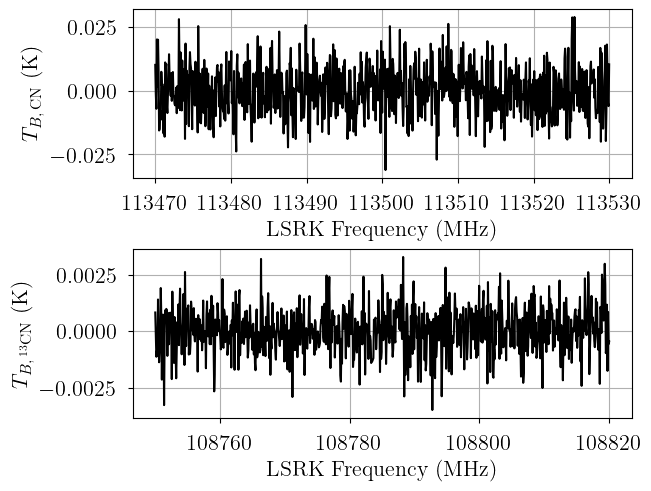

In [3]:
from bayes_spec import SpecData

# spectral axis definitions
freq_axis_12CN = np.linspace(113470, 113530, 825) # MHz
freq_axis_13CN = np.linspace(108750, 108820, 825)

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise_12CN = 0.01 # K
noise_13CN = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN = noise_12CN * np.random.randn(len(freq_axis_12CN)) # K
brightness_data_13CN = noise_13CN * np.random.randn(len(freq_axis_13CN)) # K

# Our model only expects two observations named "12CN" and "13CN"
observation_12CN = SpecData(
    freq_axis_12CN,
    brightness_data_12CN,
    noise_12CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    brightness_data_13CN,
    noise_13CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
dummy_data = {"12CN": observation_12CN, "13CN": observation_13CN}

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, dummy_data["12CN"].brightness, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, dummy_data["13CN"].brightness, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
_ = axes[1].set_ylabel(dummy_data["13CN"].ylabel)

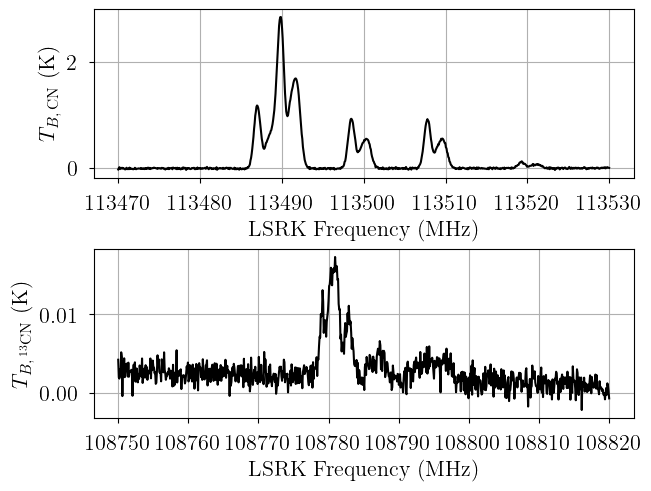

In [4]:
from bayes_cn_hfs import CNRatioModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.01, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.01, # width of the 13CN spectral rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N_12CN": [14.0, 13.5, 14.2],
    "log10_tex": [1.0, 1.2, 1.1],
    "fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
}
sim_params_12CN = sim_params.copy()
sim_params_12CN.update({
    "rms_12CN": noise_12CN,
    "baseline_12CN_norm": [-1.0, 0.5, 3.0], # normalized baseline coefficients
})
sim_params_13CN = sim_params.copy()
sim_params_13CN.update({
    "ratio_13C_12C": [0.01, 0.02, 0.005],
    "rms_13CN": noise_13CN,
    "baseline_13CN_norm": [2.0, -2.0, -3.0], # normalized baseline coefficients
})

sim_brightness_12CN = model.model["12CN"].eval(sim_params_12CN)
sim_brightness_13CN = model.model["13CN"].eval(sim_params_13CN)

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, sim_brightness_12CN, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, sim_brightness_13CN, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
_ = axes[1].set_ylabel(dummy_data["13CN"].ylabel)

In [5]:
# Now we pack the simulated spectra into a new SpecData instance
observation_12CN = SpecData(
    freq_axis_12CN,
    sim_brightness_12CN,
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    sim_brightness_13CN,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": observation_12CN, "13CN": observation_13CN}

## Model Definition: `CNRatioModel`

In [6]:
from bayes_cn_hfs import CNRatioModel

# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.01, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.01, # width of the 13CN spectral rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

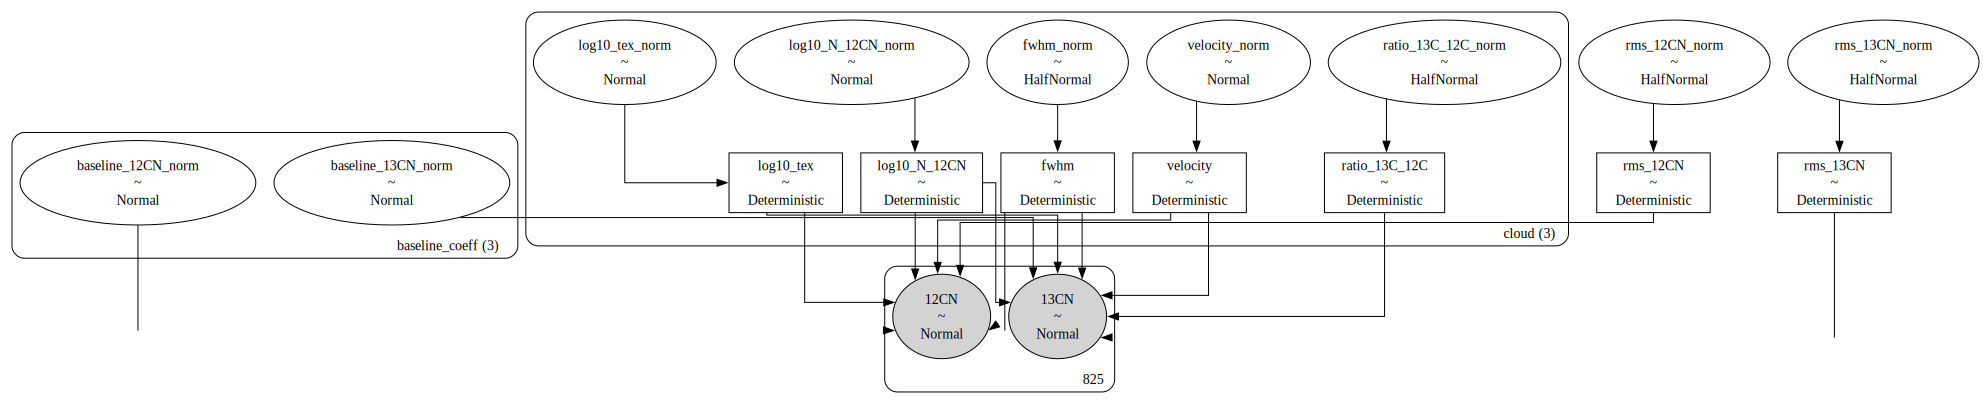

In [7]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_12CN_norm ~ Normal(0, <constant>)
baseline_13CN_norm ~ Normal(0, <constant>)
 log10_N_12CN_norm ~ Normal(0, 1)
    log10_tex_norm ~ Normal(0, 1)
         fwhm_norm ~ HalfNormal(0, 1)
     velocity_norm ~ Normal(0, 1)
ratio_13C_12C_norm ~ HalfNormal(0, 1)
     rms_12CN_norm ~ HalfNormal(0, 1)
     rms_13CN_norm ~ HalfNormal(0, 1)
      log10_N_12CN ~ Deterministic(f(log10_N_12CN_norm))
         log10_tex ~ Deterministic(f(log10_tex_norm))
              fwhm ~ Deterministic(f(fwhm_norm))
          velocity ~ Deterministic(f(velocity_norm))
     ratio_13C_12C ~ Deterministic(f(ratio_13C_12C_norm))
          rms_12CN ~ Deterministic(f(rms_12CN_norm))
          rms_13CN ~ Deterministic(f(rms_13CN_norm))
              12CN ~ Normal(f(baseline_12CN_norm, log10_N_12CN_norm, log10_tex_norm, fwhm_norm, velocity_norm), rms_12CN)
              13CN ~ Normal(f(baseline_13CN_norm, log10_tex_norm, ratio_13C_12C_norm, log10_N_12CN_norm, fwhm_norm, velocity_norm), rms_13CN)


Sampling: [12CN, 13CN, baseline_12CN_norm, baseline_13CN_norm, fwhm_norm, log10_N_12CN_norm, log10_tex_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm, velocity_norm]


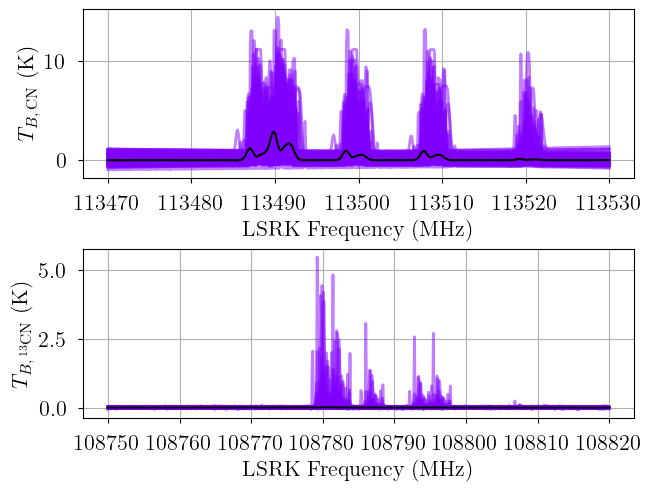

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5700
Interrupted at 5,699 [5%]: Average Loss = 2.4769e+05


Output()

Runtime: 7.52 minutes


In [11]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],14.054,0.001,14.052,14.057,0.000,0.000,883.0,951.0,NaN
log10_N_12CN[1],13.721,0.004,13.714,13.728,0.000,0.000,1105.0,988.0,NaN
log10_N_12CN[2],14.078,0.001,14.075,14.080,0.000,0.000,1006.0,940.0,NaN
log10_tex[0],0.982,0.011,0.961,1.002,0.000,0.000,1072.0,826.0,NaN
log10_tex[1],1.169,0.009,1.154,1.188,0.000,0.000,851.0,866.0,NaN
log10_tex[2],1.040,0.008,1.024,1.056,0.000,0.000,949.0,881.0,NaN
fwhm[0],3.388,0.012,3.367,3.410,0.000,0.000,706.0,943.0,NaN
fwhm[1],4.334,0.036,4.269,4.405,0.001,0.001,864.0,873.0,NaN
fwhm[2],2.289,0.006,2.277,2.300,0.000,0.000,1031.0,939.0,NaN
velocity[0],-1.762,0.006,-1.773,-1.751,0.000,0.000,757.0,914.0,NaN


Sampling: [12CN, 13CN]


Output()

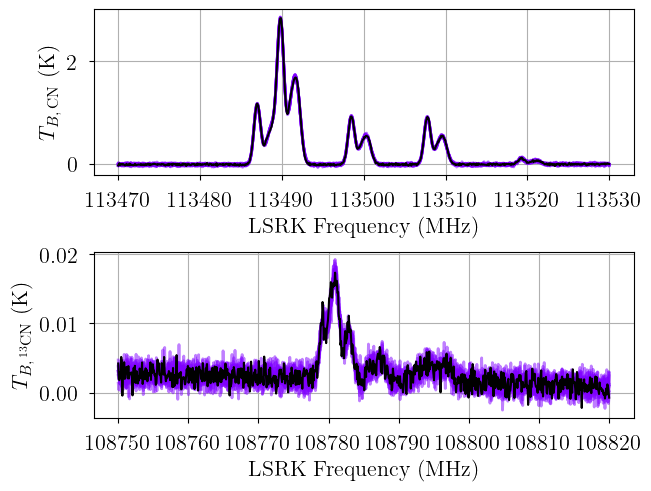

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5700
Interrupted at 5,699 [5%]: Average Loss = 2.4769e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_12CN_norm, baseline_13CN_norm, log10_N_12CN_norm, log10_tex_norm, fwhm_norm, velocity_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3929 seconds.


Adding log-likelihood to trace


Output()

Runtime: 70.34 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
pm.summary(model.trace.solution_0, var_names=model.cloud_deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],13.989,0.008,13.975,14.004,0.000,0.000,974.0,1351.0,1.0
log10_N_12CN[1],13.501,0.035,13.436,13.566,0.001,0.001,1125.0,1703.0,1.0
log10_N_12CN[2],14.200,0.002,14.196,14.204,0.000,0.000,1951.0,2433.0,1.0
log10_tex[0],0.991,0.010,0.974,1.010,0.000,0.000,3543.0,2846.0,1.0
log10_tex[1],1.106,0.060,1.001,1.227,0.001,0.001,2880.0,2309.0,1.0
log10_tex[2],1.099,0.007,1.086,1.111,0.000,0.000,2078.0,2515.0,1.0
fwhm[0],2.956,0.030,2.901,3.014,0.001,0.001,1045.0,1468.0,1.0
fwhm[1],2.072,0.049,1.980,2.165,0.001,0.001,1083.0,1604.0,1.0
fwhm[2],2.498,0.006,2.486,2.510,0.000,0.000,2035.0,2411.0,1.0
velocity[0],-2.033,0.024,-2.077,-1.988,0.001,0.001,1000.0,1427.0,1.0


Sampling: [12CN, 13CN]


Output()

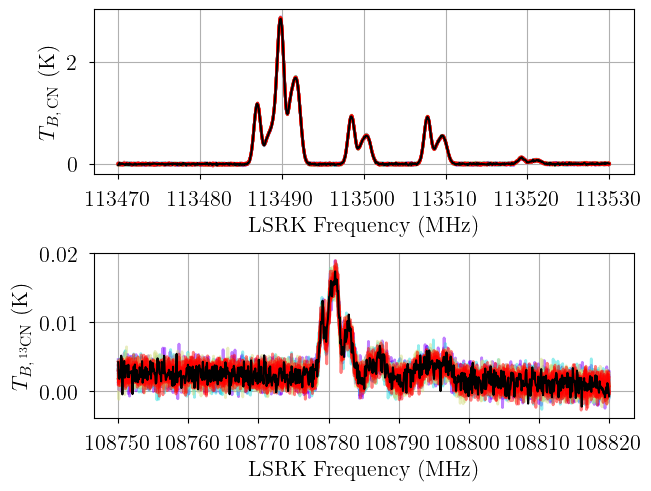

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

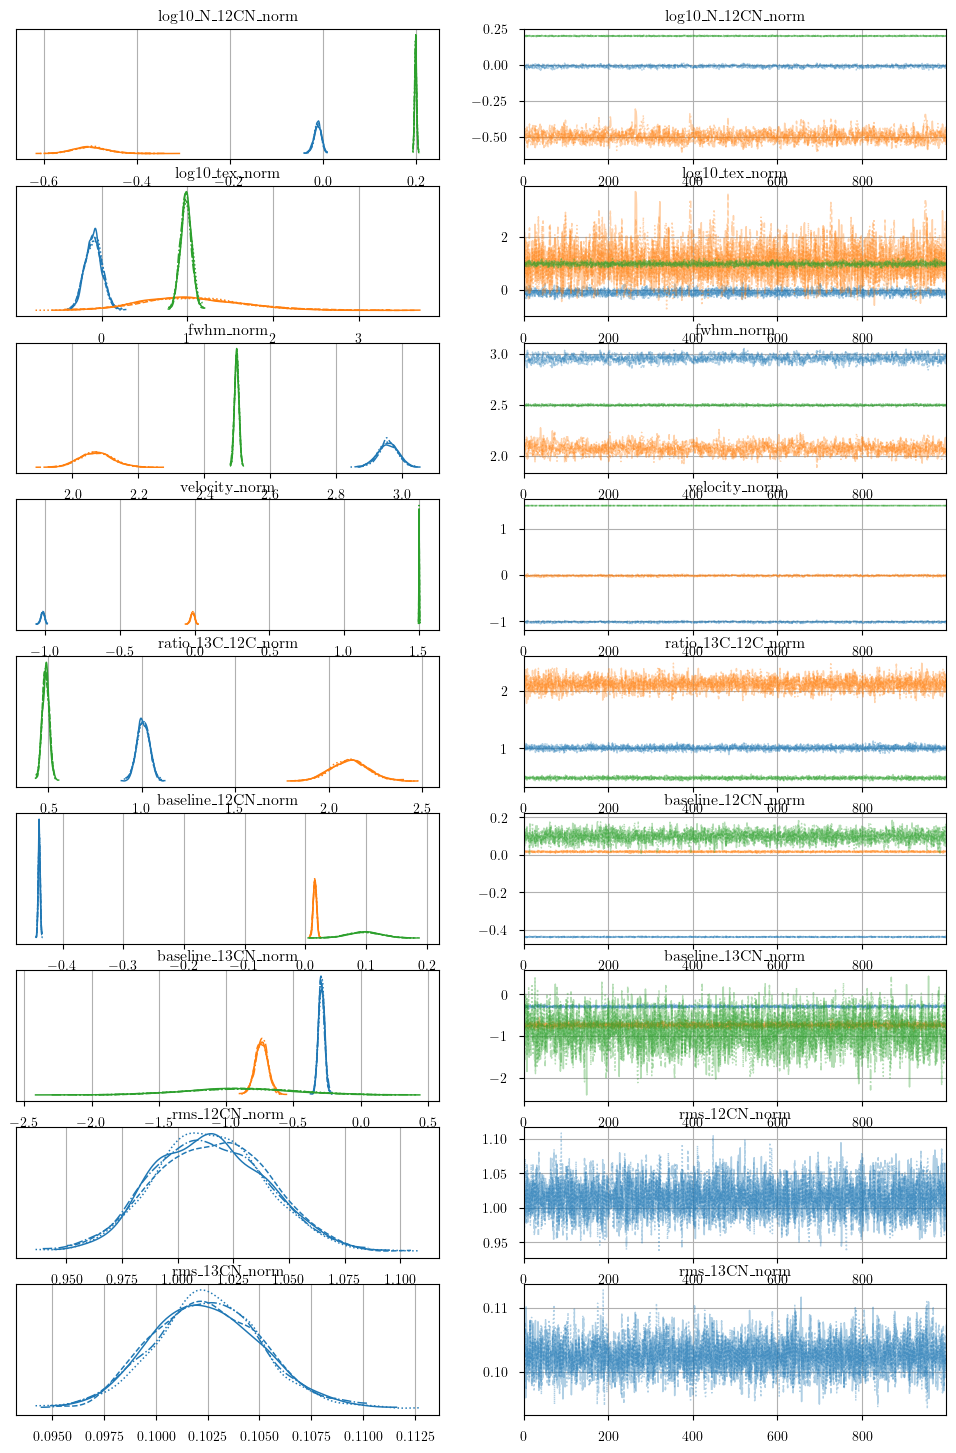

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

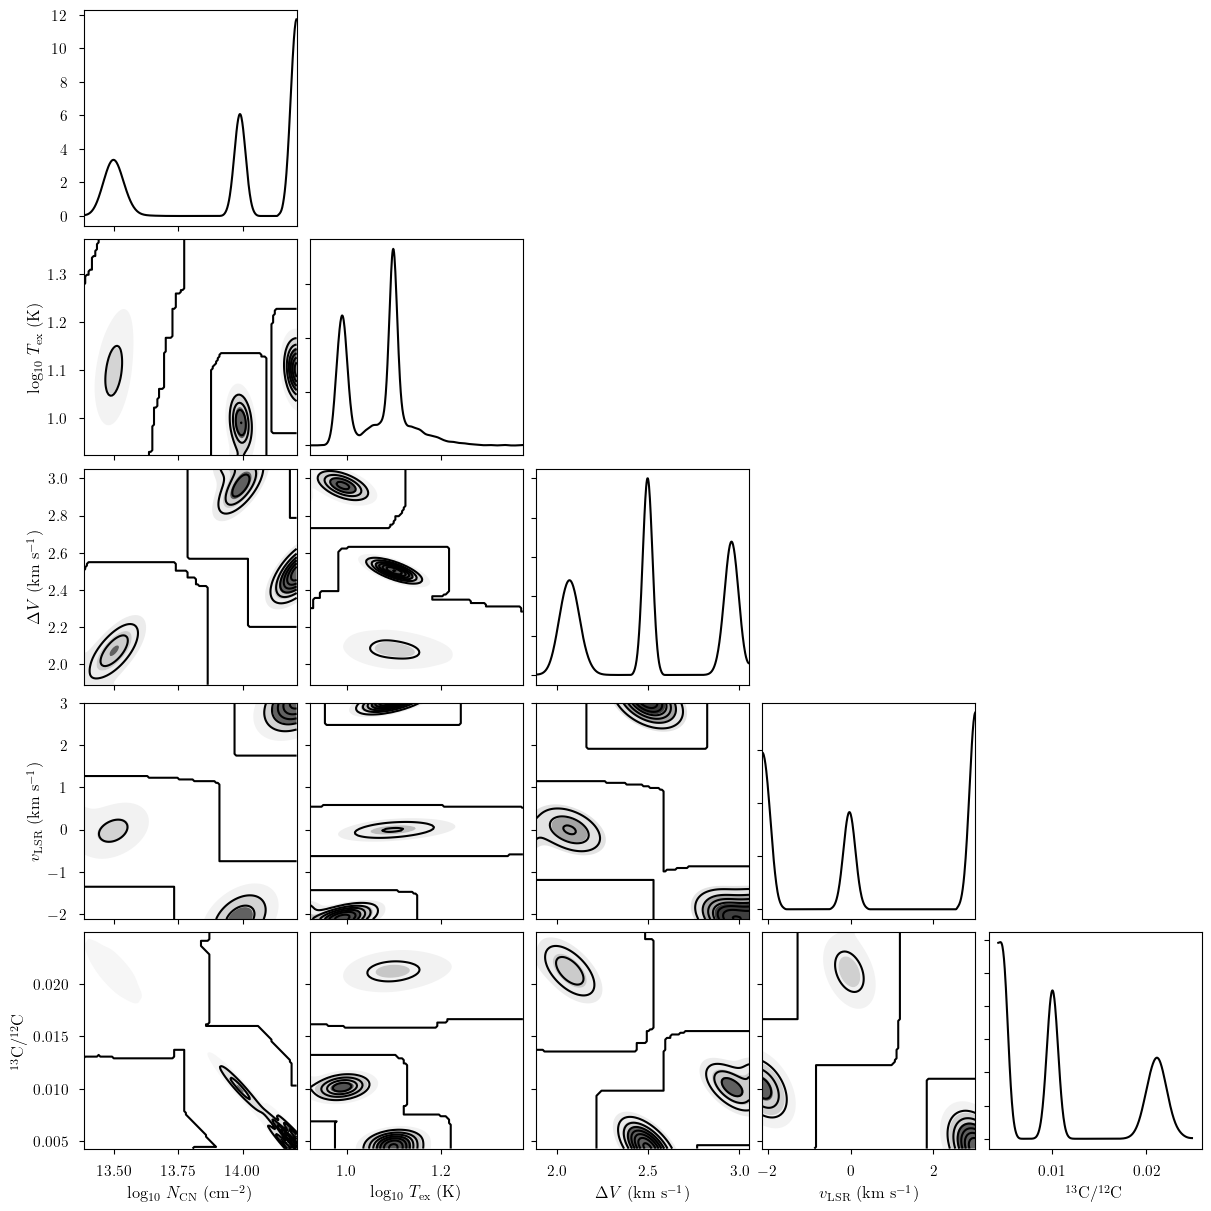

In [18]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

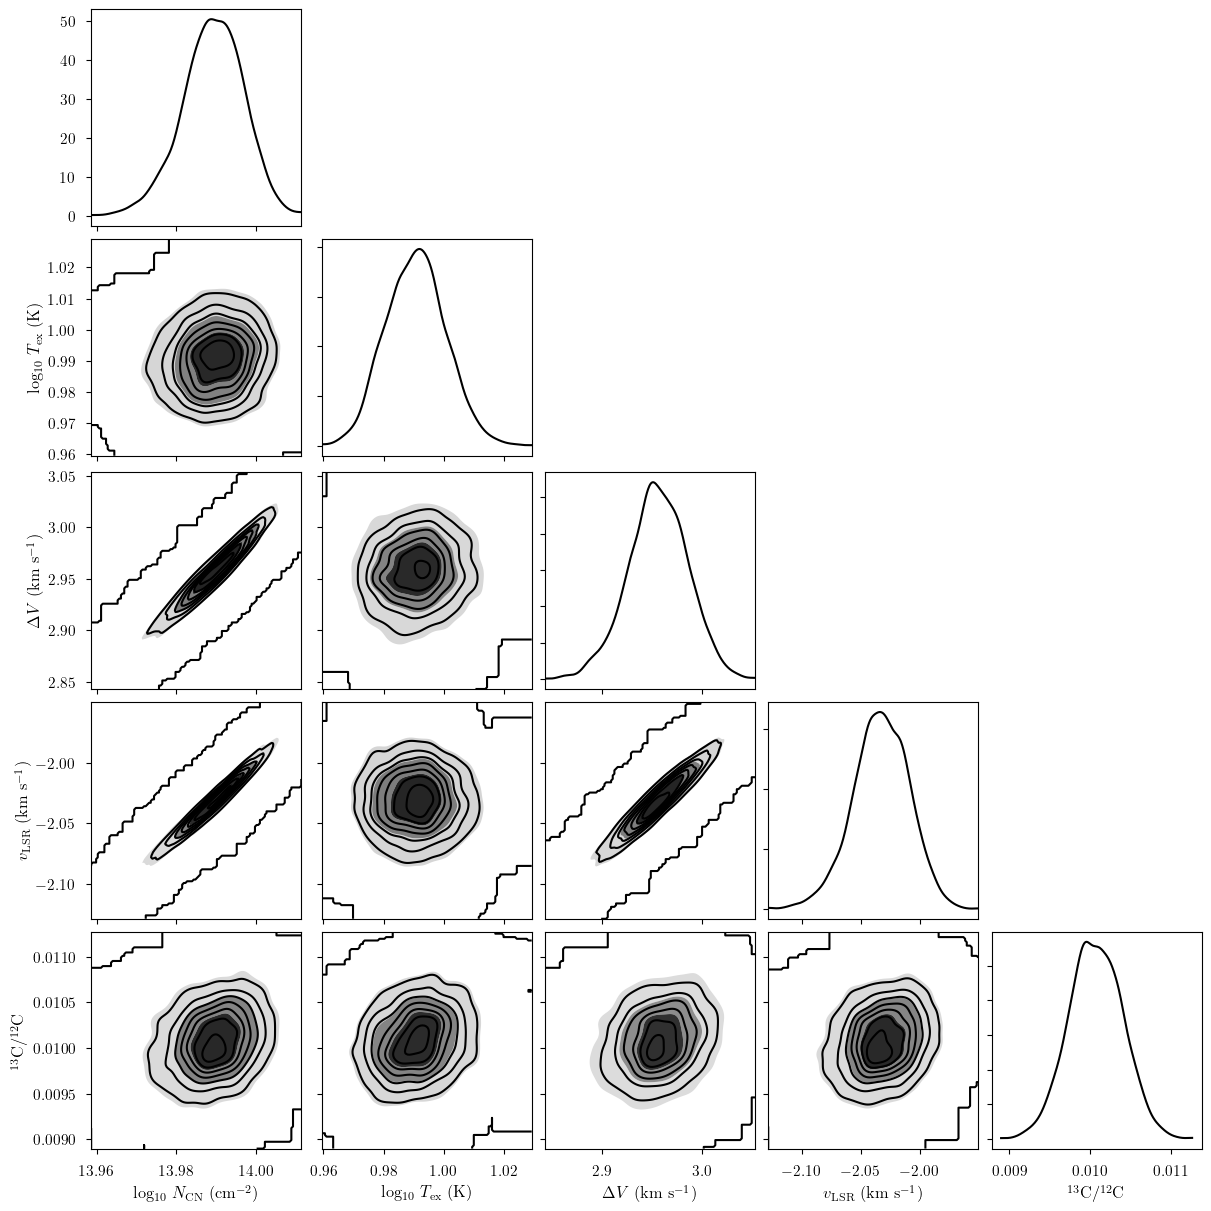

In [19]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [20]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -14081.339255249717


,mean,sd,hdi_16%,hdi_84%
log10_N_12CN[0],13.989,0.008,13.983,13.998
log10_N_12CN[1],13.501,0.035,13.461,13.528
log10_N_12CN[2],14.200,0.002,14.198,14.202
log10_tex[0],0.991,0.010,0.980,1.000
log10_tex[1],1.106,0.060,1.042,1.156
log10_tex[2],1.099,0.007,1.092,1.105
fwhm[0],2.956,0.030,2.927,2.985
fwhm[1],2.072,0.049,2.021,2.117
fwhm[2],2.498,0.006,2.491,2.504
velocity[0],-2.033,0.024,-2.056,-2.010
